## Minimizing loss subject to fairness constraints

In [11]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from random import seed
from random import randrange
from math import exp
from IPython import display
le = LabelEncoder()
plt.style.use('ggplot')

In [33]:
#import data to library
train= pd.read_csv('Train_v2.csv')

In [34]:
def DP_accuracy (y_hat,A):
    A , y_hat = np.array(A).reshape(-1) , y_hat.reshape(-1)
    sum_A0 = 0
    sum_A1 = 0
    n_A1 = np.count_nonzero(A)
    n_A0 = len(A) - np.count_nonzero(A)
    for i in range (len(y_hat)):
        sum_A0 += y_hat[i]*(1-A[i])
        sum_A1 += y_hat[i]*A[i]
    accuracy= abs(sum_A0/n_A0 - sum_A1/n_A1)
    return accuracy

def p_rule(y_pred, z_values):
    y_z_1 =np.array([i for i,j in zip(y_pred,z_values) if i==1 and j==1])
    y_z_0 = np.array([i for i,j in zip(y_pred,z_values) if i==1 and j==0])
    odds = y_z_1.sum() / y_z_0.sum()
    return  np.min([odds, 1/odds]) 

def split(y_pred,y_test,z_test): 
    pred0 =np.array([i for i,j,k in zip(y_pred,y_test,z_test) if k==0])
    pred1 = np.array([i for i,j,k in zip(y_pred,y_test,z_test) if k==1])
    y_test0 =np.array([j for i,j,k in zip(y_pred,y_test,z_test) if k==0])
    y_test1 = np.array([j for i,j,k in zip(y_pred,y_test,z_test) if k==1])
    return [pred0,y_test0,pred1,y_test1]

def classreport(pred,y_test):
    
    fp = sum(np.logical_and(y_test == 0, pred == 1)) 
    fn = sum(np.logical_and(y_test == 1, pred == 0)) 
    tp = sum(np.logical_and(y_test == 1, pred == 1)) 
    tn = sum(np.logical_and(y_test== 0, pred == 0))
    
    fpr = float(fp) / float(fp + tn)
    fnr = float(fn) / float(fn + tp)
    tpr = float(tp) / float(tp + fn)
    tnr = float(tn) / float(tn + fp)
    npv = float(tn) / float(tn + fn)
    ppv = float(tp) / float(tp + fp)
    acc = (tp + tn) / (tp + tn + fp + fn)
    di= {'False Positive': fp,
         'False Negative': fn,
         'True Positive': tp,
         'True Negative': tn,
         'False Positive rate': fpr,
         'False Negative rate': fnr,
         'True Positive rate': tpr,
         'True Negative rate': tnr,
         'npv': npv,
         'ppv': ppv,
        }
    return di

def Get_fair_metric(model,y_pred,y_test,Z_test):
    pre1,y_test1 = split(y_pred,y_test,Z_test)[0],split(y_pred,y_test,Z_test)[1]
    pre2,y_test2 = split(y_pred,y_test,Z_test)[2],split(y_pred,y_test,Z_test)[3]
    a=classreport(pre1,y_test1)
    b=classreport(pre2,y_test2)
    dp= DP_accuracy (y_pred,Z_test)
    dI=p_rule(y_pred, Z_test)
    Equalised_opportunity= a['True Positive rate']- b['True Positive rate']
    Equalised_odds = a['False Positive rate']- b['False Positive rate']
    Treatmentequal= (b['False Positive']/b['False Negative'])/(a['False Positive']/a['False Negative'])
    Predictiveequal= a['True Negative rate']- b['True Negative rate']
    condUseAcc= (a['ppv']+a['npv'])- (b['ppv']+b['npv'])
    OVerUseAcc= (a['True Positive rate']+a['True Negative rate'])- (b['True Positive rate']+b['True Negative rate'])
    D={'model': model,'Demographic Parity':dp, 'Disparate Impact':dI, 'Equalised_opportunity': Equalised_opportunity,
      'Equalised_odds': Equalised_odds, 'Treatment equality': Treatmentequal,
       'Predictive equality' : Predictiveequal, 'Conditional Use Accuracy': condUseAcc, 
      'Overall Use Accuracy': OVerUseAcc}
    return D

In [35]:
#define plot parameters
def plot(y_pred1,y_pred2,iteration=None, hmm=None):
    fig=plt.figure(figsize=[10,10])
    ax = sns.distplot(y_pred1, hist=False, kde_kws={'shade': True,},
                    norm_hist=True,
                      label='Sex=Female')
    ax = sns.distplot(y_pred2, hist=False, kde_kws={'shade': True,},
                      norm_hist=True,
                          label='Sex=Male')
    ax.set_ylabel('prediction distribution')
    ax.set_xlabel(r'P{Bank account=Yes}')
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if hmm is not None:
        fig.text(1.0, 0.65, '\n'.join(["Cov reached"]),
                 fontsize='16')

    return fig

In [36]:
#preload data
def preload_data(data):
    X= data.drop(['uniqueid'],axis=1)
    categorical_feature_mask = X.dtypes==object
    categorical_cols = X.columns[categorical_feature_mask].tolist()
    categorical_cols.append('year')
    X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
    Y= X['bank_account']
    X=X.drop(['bank_account'],axis=1)
    X=pd.concat([X,Y],axis=1)
    return X
X=preload_data(train)

In [37]:
#Get tuple of data
dataset=[]
for i in range(len(X)):
    dataset.append(list((X.iloc[i]).values))
column =[i for i in X]

In [38]:
# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column])

# find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds,l_rate, n_epoch, eps, penalty,fair,sensitive_attr_column,protected_group_code, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in range(len(folds)-1):
        folds = cross_validation_split(dataset, n_folds)
        train_set = folds
        train_set.remove(folds[fold])
        train_set = sum(train_set, [])
        test_set = list()
        foll= folds[fold]
        for row in foll:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set,l_rate,n_epoch, eps, penalty,fair,sensitive_attr_column,protected_group_code, *args)
        A= [row[sensitive_attr_column] for row in foll]
        actual = [row[-1] for row in foll]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores,actual,predicted,A

# Make a prediction with coefficients
def predict(row, coefficients):
    yhat = coefficients[0]
    for i in range(len(row)-1):
        yhat += coefficients[i + 1] * row[i]
    return 1.0 / (1.0 + exp(-yhat))

# compute the covarience
def covarience(train,coefficients):
    yhat = coefficients[0]
    actual = np.array([row[-1] for row in train])
    G=[]
    for row in train:
        for i in range(len(row)-1):
            yhat += coefficients[i + 1] * row[i]
        sign_dist= np.sign(yhat)
        
#        g1= np.dot(((1+actual)/2),actual)
#        g2= np.dot(((1-actual)/2),actual)
        g= np.minimum(0,np.dot(actual,sign_dist))

        G.append(g)
    return G

def weight(train,coef):
    actual = np.array([row[-1] for row in train])
    yhay=[]
    for row in train:
        yhat = predict(row, coef)
        yhay.append(yhat)
        error = row[-1] - yhat     
        coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)
        for i in range(len(row)-1):
            coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
    return coef,yhay
# Estimate logistic regression coefficients using stochastic gradient descent
def coefficients_sgd(train, l_rate, n_epoch, eps, penalty,fair,sensitive_attr_column,protected_group_code):
    coef1 = [0.0 for i in range(len(train[0]))]
    coef2 = [0.0 for i in range(len(train[0]))]
    coef = [0.0 for i in range(len(train[0]))]

    train1= [i for i in train if i[sensitive_attr_column]==protected_group_code]
    train2= [i for i in train if i[sensitive_attr_column]!=protected_group_code]
    N0 = len(train1)
    N1 = len(train2)
    N= len(train)
    G1 = covarience(train1,coef)
    G2 = covarience(train2,coef)
    coef1,yhat1= weight(train1,coef)
    coef2,yhat2= weight(train2,coef)
    fig=plt.figure()
    plot(yhat1,yhat2)
    cov = ((-N1/N**2)*sum(sum(G1)))+((N0/N**2)*sum(sum(G1)))
    print (cov)
    if fair == 'No':
        global cov1
        cov1=[cov]
        for epoch in range(n_epoch):
            G1 = covarience(train1,coef)
            G2 = covarience(train2,coef)
            coef1,yhat1= weight(train1,coef)
            coef2,yhat2= weight(train2,coef)
            coef,yhat = weight(train,coef)
            cov = ((-N1/N**2)*sum(sum(G1)))+((N0/N**2)*sum(sum(G1)))
            cov1.append(cov)
            print(cov)
    else:
        C=1
        global cov2
        cov2=[cov]
#         coef,yhat = sth(train,coef)
        for epoch in range(n_epoch):
            G1 = covarience(train1,coef)
            G2 = covarience(train2,coef)
            coef1,yhat1= weight(train1,coef)
            coef2,yhat2= weight(train2,coef)
            C += penalty
            coef= (C*coef1 + coef2)
            cov = ((-N1/N**2)*sum(sum(G1)))+((N0/N**2)*sum(sum(G1)))
            cov2.append(cov)
            plot(yhat1,yhat2)
            if (cov >= eps or cov <= -eps):
                print(cov)
                continue
            else: 
                print('cov below E:', cov)
                continue
    return coef

# Linear Regression Algorithm With Stochastic Gradient Descent
def logistic_regression(train, test, l_rate, n_epoch, eps, penalty,fair,sensitive_attr_column,protected_group_code):
    predictions = list()
    coef = coefficients_sgd(train, l_rate, n_epoch, eps, penalty,fair,sensitive_attr_column,protected_group_code)
    for row in test:
        yhat = predict(row, coef)
        yhat = round(yhat)
        predictions.append(yhat)
    return(predictions)

## Unfair Classifier

In [39]:
# Test the logistic regression algorithm on the our dataset
seed(1)

# load and prepare data
for i in range(len(column)):
    str_column_to_float(dataset, i)
# normalize
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

# define parameters 
n_folds = 2
l_rate = 0.1
n_epoch = 4
eps= 0.012
penalty=2
fair='No'
sensitive_attr_column = 6
protected_group_code = 0


0.0
-80.85605974019495
-0.03482173115426139
-0.011607243718087128
-0.011607243718087128
Scores: [87.84220370685257]
DP: 0.04724735920952407
Roc-Score: 0.6110027513965487
Mean Accuracy: 87.842%


<Figure size 432x288 with 0 Axes>

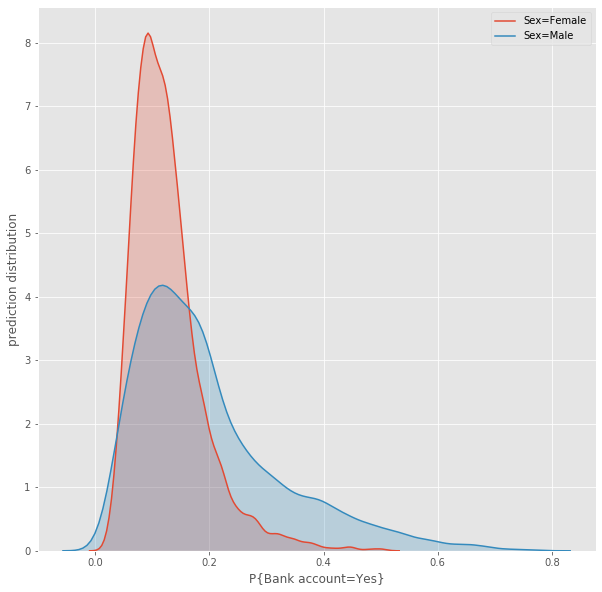

In [40]:
#evaluate algorithm
scores,actual,predicted,A = evaluate_algorithm(dataset, logistic_regression, n_folds, l_rate, n_epoch, eps, penalty,fair,sensitive_attr_column,protected_group_code)
print('Scores: %s' % scores)
actual=np.array(actual)
predicted =np.array(predicted)
print('DP: %s' %DP_accuracy(predicted,A))
print('Roc-Score: %s' %roc_auc_score(actual,predicted))
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

In [42]:
#Get fair values
E=Get_fair_metric('Unfair', predicted,actual,A)
E=pd.DataFrame([E])
#visualise
E

,model,Demographic Parity,Disparate Impact,Equalised_opportunity,Equalised_odds,Treatment equality,Predictive equality,Conditional Use Accuracy,Overall Use Accuracy
0,Unfair,0.047247,0.577128,-0.096849,-0.019306,1.536143,0.019306,0.028354,-0.077544


## Fair Classifier

In [31]:
fair='Yes'

0.0
-0.131842906762621
-0.021973817793770174
-0.021973817793770174
-0.021973817793770174
Scores: [86.85597687468118]
DP: 0.03217018497445793
Roc-Score: 0.6384165829265034
Mean Accuracy: 86.856%


<Figure size 432x288 with 0 Axes>

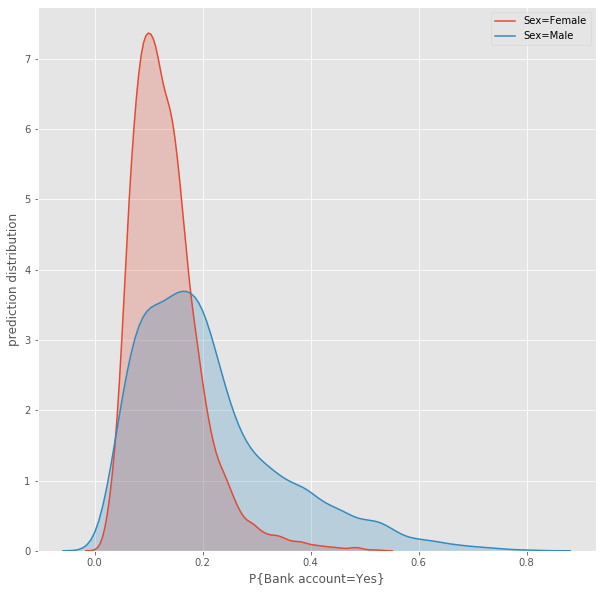

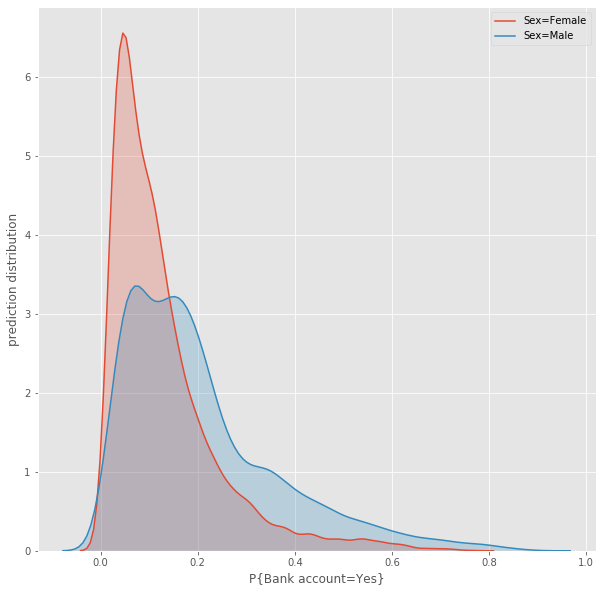

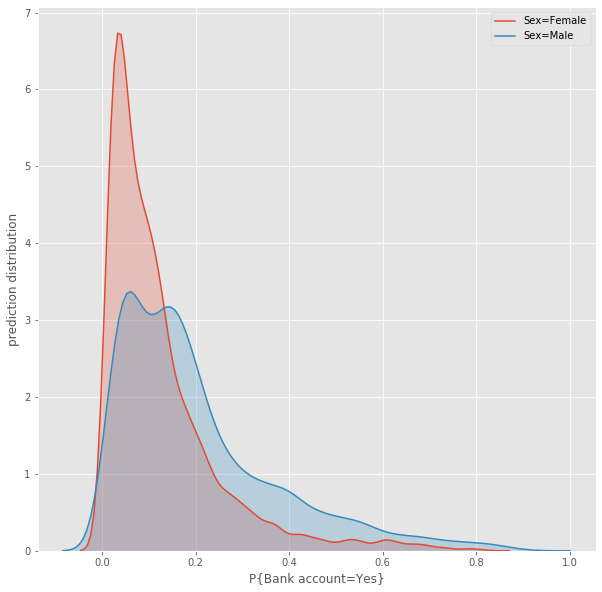

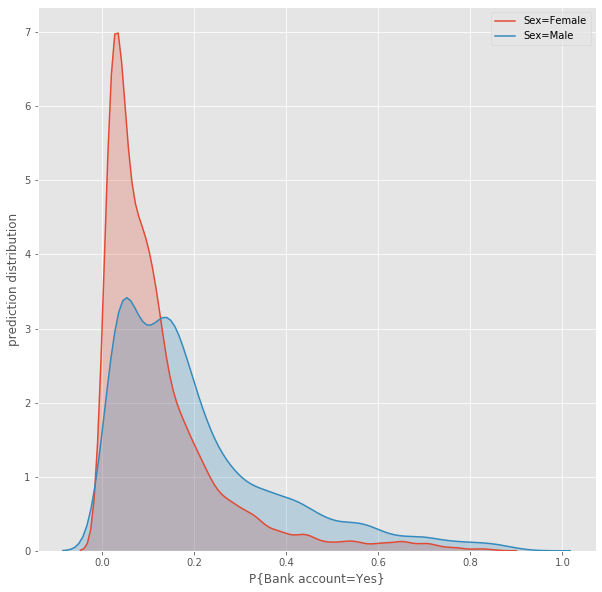

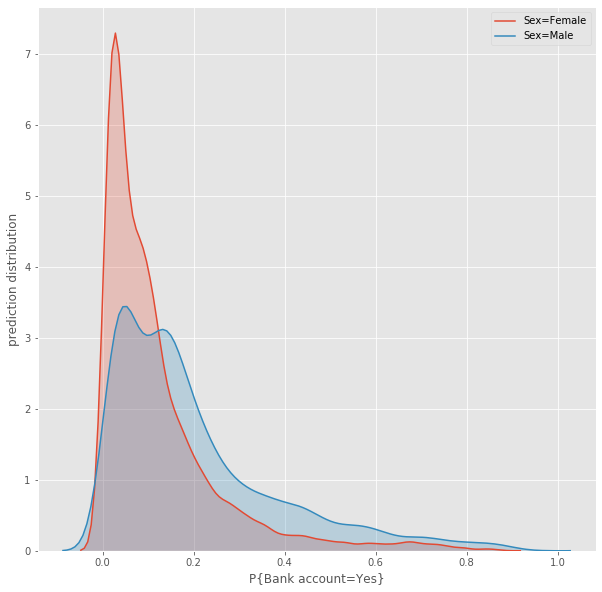

In [32]:
#evaluate algorithm
scores,actual,predicted,A = evaluate_algorithm(dataset, logistic_regression, n_folds, l_rate, n_epoch, eps, penalty,fair,sensitive_attr_column,protected_group_code)
print('Scores: %s' % scores)
actual=np.array(actual)
predicted =np.array(predicted)
print('DP: %s' %DP_accuracy(predicted,A))
print('Roc-Score: %s' %roc_auc_score(actual,predicted))
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

In [28]:
#Get fair values
D=fair.Get_fair_metric('Fair', predicted,actual,A)
D=pd.DataFrame([D])
#visualize
D

,model,Demographic Parity,Disparate Impact,Equalised_opportunity,Equalised_odds,Treatment equality,Predictive equality,Conditional Use Accuracy,Overall Use Accuracy
0,Fair,0.008661,0.809942,0.056823,0.000804,0.471796,-0.000804,-0.029688,0.056019


In [29]:
#compare
Res=pd.concat([D,E])
T=Res.T
#visualize
T

,0,0
model,Fair,Unfair
Demographic Parity,0.00866086,0.0463107
Disparate Impact,0.809942,0.571038
Equalised_opportunity,0.0568227,-0.0967957
Equalised_odds,0.000803986,-0.0187657
Treatment equality,0.471796,1.54501
Predictive equality,-0.000803986,0.0187657
Conditional Use Accuracy,-0.0296879,0.0276059
Overall Use Accuracy,0.0560187,-0.07803
